In [195]:
import cv2
import os
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.signal
from google.colab.patches import cv2_imshow
from skimage import segmentation
from skimage import io, color
import skimage
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import tensorflow as tf
from keras.applications.vgg16 import preprocess_input 
from keras.applications.vgg16 import VGG16 
from keras.models import Model
from tensorflow.keras import datasets, layers, models

import zipfile

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
def label2rgb(labels):
  """
  Convert a labels image to an rgb image using a matplotlib colormap
  """
  label_range = np.linspace(0, 1, 256)
  lut = np.uint8(plt.cm.viridis(label_range)[:,2::-1]*256).reshape(256, 1, 3) # replace viridis with a matplotlib colormap of your choice
  return cv2.LUT(cv2.merge((labels, labels, labels)), lut)

In [8]:
def cluster_centers(superpixel_map):
  """ 
  Take a superpixel map and return a list with the 
  (row,col) positions of the cluster centers for that map
  """

  x_centers = np.zeros(len(np.unique(superpixel_map)))
  y_centers = np.zeros_like(x_centers)
  counts = np.zeros_like(x_centers)
  rows, cols = superpixel_map.shape

  for row in range(rows):
    for col in range(cols):
      x_centers[superpixel_map[row, col]] += col
      y_centers[superpixel_map[row, col]] += row
      counts[superpixel_map[row, col]] += 1

  x_centers = np.round(x_centers/counts).astype('int')
  y_centers = np.round(y_centers/counts).astype('int')
  centers = list(zip(y_centers, x_centers))


  return centers

In [9]:
def apply_supermap(img, superpixel_map):
  """ 
  This function returns an image where we assign the color of the cluster centers 
  to every pixel of their corresponding segmentation groups.
  """
  centers = cluster_centers(superpixel_map)
  out = np.zeros_like(img)
  for i,(row, col) in enumerate(centers):
    out[superpixel_map == i] = img[row, col]
  return out

In [10]:
def color_histogram(img, mask, num_bins):
  """
  For each channel in the image, compute a color histogram
  Mask is a matrix of booleans the same size as image.
  """

  rows, cols, channels = img.shape
  histogram = [None]

  for ch in range(channels):
    his, b = np.histogram(img[:,:,ch][mask], num_bins)
    his = his/np.sum(mask)
    histogram = np.hstack((histogram, his))
  histogram  = np.delete(histogram, 0)
  return histogram

In [11]:
def average_node_degree(adjMatrix):
  """ 
  Take an adjacency matrix and return
  the average number of neighborghs that the segments have 
  """
  
  return adjMatrix.sum()/len(adjMatrix[:,1])

In [12]:
def adjacencyMatrix(superpixel_map):
  """
  Compute the adjacency matrix for the superpixel map
  The input is a superpixel map and the output is a binary adjacency matrix NxN 
  """

  segmentList = np.unique(superpixel_map)
  segmentNum = len(segmentList)
  adjMatrix = np.zeros((segmentNum, segmentNum))
  rows, cols = superpixel_map.shape

  for s in range(rows-2):
    s = s+1
    for t in range(cols-2):
      t = t+1
      msk = superpixel_map[s,t]
      if superpixel_map[s+1,t] != msk:
        adjMatrix[msk, superpixel_map[s+1,t]] = 1
      if superpixel_map[s-1,t] != msk:
        adjMatrix[msk, superpixel_map[s-1,t]] = 1
      if superpixel_map[s,t+1] != msk:
        adjMatrix[msk, superpixel_map[s,t+1]] = 1
      if superpixel_map[s,t-1] != msk:
        adjMatrix[msk, superpixel_map[s,t-1]] = 1

  return adjMatrix

In [13]:
def filter_segments(edges, seg_id, min_size):
  """
  Merge all of the small, unnecessary components that result from uneven regions
  """

  num_edges = edges.shape[0]

  for e in edges:
    if seg_id[int(e[0])] != seg_id[int(e[1])]:
      s1 = seg_id[int(e[0])]
      s2 = seg_id[int(e[1])]
      if np.sum(seg_id == s2) < min_size:
        for s in range(len(seg_id)):
          if seg_id[s] == s2:
            seg_id[s] = s1
      if np.sum(seg_id == s1) < min_size:
        for s in range(len(seg_id)):
          if seg_id[s] == s1:
            seg_id[s] = s2

  return seg_id

In [14]:
def compute_MSF_edges(superpixel_map, adjMatrix, centers, features):
  """
  The edge weight is defined as the product of (1) difference of histograms
  (or equivalently, 1-intersection of histograms/3), and (2) inverse
  proximity exp(D(a,b)) with D specified below. 
  """


  rows, cols = superpixel_map.shape
  dnorm = np.sum(rows**2 + cols**2)
  n, b  = adjMatrix.shape
  adjmod = np.triu(adjMatrix)
  G = np.array([0, 0, 0])
  
  for s in range(n):
    for t in range(b):
      if adjmod[s, t] == 1: 
        dist = ((centers[s][1] - centers[t][1])**2 + (centers[s][0] - centers[t][0])**2)
        vec = [s, t, (1-np.sum(np.minimum(features[s], features[t]))/3)*np.exp(dist/dnorm)]
        G = np.vstack((G,vec))
  G = np.delete(G, 0, 0)
  return G

In [15]:
def reduce(img, superpixel_map, num_bins=10):
  """Take as input an image, its corresponding superpixel map, and a 
  number of bins as input
  Output is a list of feature vectors. 
  """

  feature_vectors = []
  num_segments = len(np.unique(superpixel_map))
  for i in range(num_segments):
      mask = superpixel_map == i
      feature_vectors.append(color_histogram(img, mask, num_bins))
  return(feature_vectors)

In [462]:
def MSF(edges, k, filter_min_size=None):
  """Felzenszwalb-Huttenlocher algorithm implementation, which is a modified
  version of the Kruskal algorithm.
  Input  edges: mx3 matrix, the adjacency list of a graph, of which each row is 
            an edge (node1, node2, weights). 
         m: is the number of edges.
         k: hyperparameter for F-H algorithm
         filter_size: if a filter size is passed, this will remove groups from the 
         segmentation that have less than filter_size superpixels
  Output seg: array of size (n,), the segment id assigned to each node in the graph
              n is the number of nodes
  """

  num_edges = edges.shape[0]
  num_nodes = int(np.max(edges[:,:2])) +1

  edges = edges[np.argsort(edges[:,2]), :]
 
  seg_id = np.array(list(range(1,num_nodes+2)))
  
  maxw_id = np.zeros(num_nodes+1)
  numn_id = np.ones(num_nodes+1)

  for e in edges:
    if seg_id[int(e[0])] != seg_id[int(e[1])]:
      s1 = seg_id[int(e[0])]
      s2 = seg_id[int(e[1])]
      mint = np.minimum(maxw_id[s1] + k/numn_id[s1], maxw_id[s2] + k/numn_id[s2])
      if e[2] < mint:
        for s in range(len(seg_id)):
          if seg_id[s] == s2:
            seg_id[s] = s1
            numn_id[s1] += 1
        if e[2] > maxw_id[s1]:
          maxw_id[s1] = e[2]
        if maxw_id[s2] > maxw_id[s1]:
          maxw_id[s1] = maxw_id[s2]
   

  if filter:
    # Postprocessing to remove fragments
    seg_id = filter_segments(edges, seg_id, filter_min_size)
 
  return seg_id 

In [463]:
def build_msf_map(segmentation, superpixel_map):
  """
  Take the resulting segmentation and apply it to the super pixel map
  """
  num_nodes = len(segmentation)
  map = np.zeros_like(superpixel_map)
  rows, cols = map.shape
  for row in range(rows):
    for col in range(cols):
      map[row, col] = segmentation[superpixel_map[row, col]]
  return map

In [312]:
def IdObjects(img):
  """
  Given an image return a segmentated map of all objects and their centers
  """
  super_img = skimage.segmentation.slic(img, n_segments=400, compactness=8, max_iter=15)

  img_features = reduce(img, super_img)
  img_centers = cluster_centers(super_img)
  adjMatrix_img = adjacencyMatrix(super_img)

  edges_img = compute_MSF_edges(super_img, adjMatrix_img, img_centers, img_features)

  segmentation_img = MSF(edges_img, 2, 7)
  img_map = build_msf_map(segmentation_img, super_img)

  return renameSmap(img_map), cluster_centers(img_map)

In [19]:
def renameSmap(superpixel_map):
  """
  Relabel the segmented map with ordered segment numbers
  """
  id = 0
  for val in np.unique(superpixel_map):
    superpixel_map[superpixel_map == val] = id
    id += 1
  return superpixel_map

In [20]:
def modSuper(img, center):
  """
    Take a segmented object and apply a random rotation/distortion
    transform to it based on object center.
    Rotation is evenly distributed
    Distortion is based on a gaussian distrobution
  """

  d = random.uniform(0, 2*np.pi)
  dis = np.random.normal(0, .25, 4) + [1,1,1,1]
  rmat = [[dis[0]*np.cos(d), -dis[1]*np.sin(d)], [dis[2]*np.sin(d), dis[3]*np.cos(d)]]

  rows, cols, c = img.shape
  newimg = np.zeros_like(img)
  for row in range(rows):
    for col in range(cols):
      if not img[row,col,1] == 0:
        idx = np.array([row-center[0], col-center[1]])
        newidx = np.dot(rmat, idx)+center
        newimg[round(newidx[0]), round(newidx[1]), :] = img[row,col,:]
  return newimg

In [282]:
def load_images(folder):
  '''
  Load in all images in a folder into an array
  Resize the images to (224,244,3)
  '''
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            res = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
            images.append(res)
    return images

In [22]:
def def_background(img):
  '''
  Determine which segments in an image are background
  *Currently unused, but could be useful later*
  '''
  h,w = img.shape
  segs = [0,0,0,0,0,0,0,0,0]
  for i in range(1,5):
    for j in range(1,5):
      segs[img[round(h*i/5), round(w*j/5)]] += 1
  return segs.index(max(segs))

In [23]:
def check_bound(img):
  '''
  Make sure that a segment is not on the boarder of the image
  If it is, it can't be rotated or distorted without exiting the frame
  '''
  h,w,c = img.shape
  on_edge = 0
  for i in range(h):
    if np.any(img[i,0,:] != 0) or np.any(img[i,w-1,:] != 0):
      on_edge = 1
  for j in range(w):
    if np.any(img[0,j,:] != 0) or np.any(img[h-1,j,:] != 0):
      on_edge = 1
  return on_edge

In [25]:
#Load in data from mounted google drive
!unzip /content/gdrive/MyDrive/Training_Photos.zip -d T_data

Archive:  /content/gdrive/MyDrive/Training_Photos.zip
  inflating: T_data/IMG_20210307_121843.jpg  
  inflating: T_data/IMG_20210307_121835.jpg  
  inflating: T_data/IMG_20210307_121748.jpg  
  inflating: T_data/IMG_20210307_121737.jpg  
  inflating: T_data/IMG_20210307_121715.jpg  
  inflating: T_data/IMG_20210307_121701.jpg  
  inflating: T_data/IMG_20210307_121651.jpg  
  inflating: T_data/IMG_20210302_094436.jpg  
  inflating: T_data/IMG_20210302_094433.jpg  
  inflating: T_data/IMG_20210302_094431.jpg  
  inflating: T_data/IMG_20210302_094427.jpg  
  inflating: T_data/IMG_20210302_094421.jpg  
  inflating: T_data/IMG_20210307_121909.jpg  
  inflating: T_data/IMG_20210307_121853.jpg  


In [27]:
!unzip /content/gdrive/MyDrive/Testing_Photos.zip -d Test_data

Archive:  /content/gdrive/MyDrive/Testing_Photos.zip
  inflating: Test_data/IMG_20210307_151139.jpg  
  inflating: Test_data/IMG_20210307_151126.jpg  
  inflating: Test_data/IMG_20210307_151113.jpg  


In [432]:
#Load from unzipped files
Trainings = load_images('/content/T_data')
Tests = load_images('/content/Test_data')

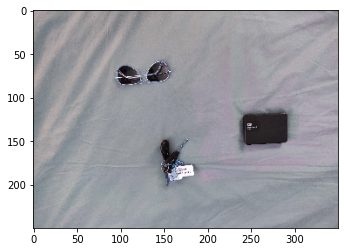

In [29]:
plt.imshow(Trainings[0])

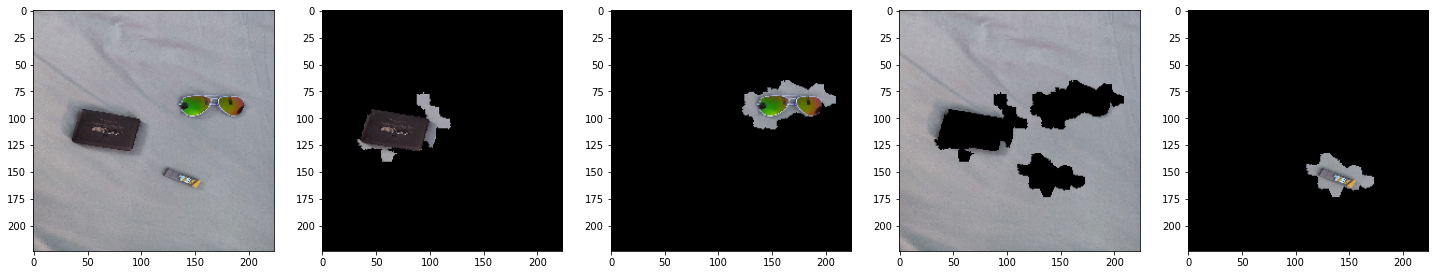

In [313]:
#Test segmentation on an image
img = Trainings[3].copy()
img_map, centers = IdObjects(img)
fig, ax = plt.subplots(1, len(np.unique(img_map))+1, figsize=(25,25))
ax[0].imshow(img)
for i in np.unique(img_map):
  newim = img.copy()
  newim[~(img_map == i),:] = [0,0,0]
  ax[i+1].imshow(newim)

In [314]:
#Segment all the traing images
segs = []
segs_centers = []
for img in Trainings:
  img_map, centers = IdObjects(img)
  for id in np.unique(img_map):
    newim = img.copy()
    newim[~(img_map == id),:] = [0,0,0]
    segs_centers.append(centers[id])
    segs.append(newim)

In [261]:
#Load feature identification model
model = VGG16()

In [262]:
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [315]:
#Preprocess and run each segmented object through feature ID
seg_vec = []
h,w,c = segs[0].shape
for seg in segs:
  prep_im = preprocess_input(np.reshape(cv2.resize(seg, dsize=(224,224), interpolation=cv2.INTER_CUBIC), (1,224,224,3)))
  features = model.predict(prep_im, use_multiprocessing=True)
  seg_vec.append(features)

In [316]:
features = np.array(seg_vec).reshape(-1,4096)

In [348]:
#Group objects with K-means on feature vectors
kmeans = KMeans(n_clusters=6,n_jobs=-1, random_state=22)
fitvec = kmeans.fit(features)

In [349]:
kmeans.labels_

array([0, 2, 1, 0, 3, 0, 1, 0, 2, 3, 1, 2, 5, 4, 0, 5, 0, 0, 1, 5, 0, 1,
       1, 5, 3, 0, 0, 1, 0, 3, 0, 4, 5, 0, 2, 5, 4, 0, 0, 4, 2, 0, 0, 0,
       1, 0, 0, 2, 1, 4, 0, 2, 5, 2], dtype=int32)

(array([ 0,  3,  5,  7, 14, 16, 17, 20, 25, 26, 28, 30, 33, 37, 38, 41, 42,
       43, 45, 46, 50]),)
Object:  0
Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f8d35251320> (for post_execute):


KeyboardInterrupt: ignored

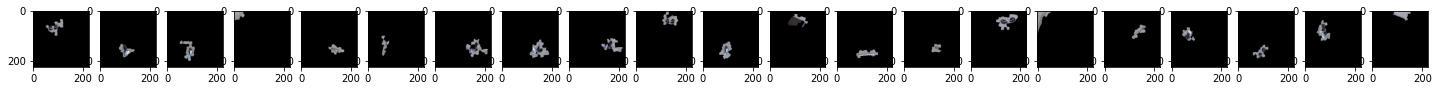

In [458]:
#Print an example of the objects in the given classification for reference
num = 0
ixs = np.where(kmeans.labels_ == num)
print('Object: ', num)
fig, ax = plt.subplots(1, len(ixs[0]), figsize=(25,25))
j = 0;
for i in ixs[0]:
   ax[j].imshow(segs[i])
   j += 1

Object:  3


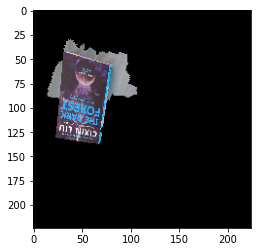

In [461]:
#Show one example of object 3
ixs = np.where(kmeans.labels_ == 3)
print('Object: ', 3 )
plt.imshow(segs[ixs[0][1]])
plt.show()

In [361]:
#Distort the object data for input into the trained model
#This Creates a larger training set
Training_X = []
Labels = []
for i in range(len(segs)):
  if not check_bound(segs[i]):
    for r in range(16):
      try:
        rotImg = modSuper(segs[i], segs_centers[i])
        Training_X.append(rotImg)
        Labels.append(kmeans.labels_[i])
      except:
        Training_X.append(segs[i])
        Labels.append(kmeans.labels_[i])
  else:
    for r in range(16):
      Training_X.append(segs[i])
      Labels.append(kmeans.labels_[i])

In [394]:
Training_x = np.array(Training_X)/255
#Test_x = np.array(Test_X)/255
Labels_oh = tf.one_hot(Labels, len(segs))
#Test_Labels_oh = tf.one_hot(Test_Labels, len(segs))
Training_x.shape

(864, 224, 224, 3)

In [384]:
#Generate a standard keras CNN netowrk
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(len(segs)))
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 52, 52, 64)        36928     
_________________________________________________________________
flatten_4 (Flatten)          (None, 173056)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)               

In [385]:
#Traing the network on the given data
model2.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model2.fit(Training_x, Labels_oh, epochs=2, shuffle=True)

Epoch 1/2
27/27 [==============================] - 59s 2s/step - loss: 1.9356 - accuracy: 0.5871
Epoch 2/2
27/27 [==============================] - 58s 2s/step - loss: 0.1281 - accuracy: 0.9420


In [437]:
#Segment the test images
Test_imgs = []
for img in Tests:
  img_segs = []
  img_segs_centers = []
  img_map, centers = IdObjects(img)
  for id in np.unique(img_map):
    newim = img.copy()
    newim[~(img_map == id),:] = [0,0,0]
    img_segs.append((newim/255,centers[id]))
  Test_imgs.append(img_segs)

In [438]:
#FOr each object in a given image predict the classification of each object
seg_ids = []
img = Test_imgs[1]
for seg in img:
  y_pred=np.argmax(model2.predict(np.array([seg[0]])), axis=-1)
  seg_ids.append(y_pred[0])

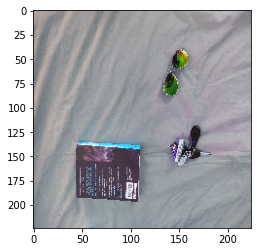

In [439]:
plt.imshow(Tests[1])

In [423]:
# font 
font = cv2.FONT_HERSHEY_SIMPLEX 
  
# org 
org = (50, 50) 
  
# fontScale 
fontScale = 1
   
# Blue color in BGR 
color = (255, 0, 0) 
  
# Line thickness of 2 px 
thickness = 2

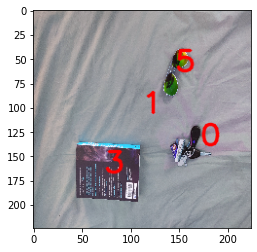

In [450]:
#Print the label for each object onto the image at the center of the object segmentation
image = Tests[1].copy()
for i in range(len(seg_ids)):  
  image = cv2.putText(image, str(seg_ids[i]), (Test_imgs[1][i][1][1],Test_imgs[1][i][1][0]), font,  
                   fontScale, color, thickness, cv2.LINE_AA)
plt.imshow(image)

In [449]:
print(seg_ids)
print(Test_imgs[1][1][1])

[1, 5, 3, 0]
(62, 146)


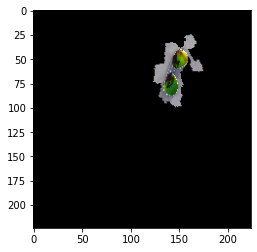

In [447]:
plt.imshow(Test_imgs[1][1][0])